In [580]:
import pandas as pd
import numpy as np
from utils.csv import create_csv_files, open_convert_csv_files
from tqdm import tqdm, tqdm_notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn

exchange_name = 'bitmex'
symbol = 'EOS/BTC'
timeframe = '1m'
start = '01/07/2019'
end = '05/07/2019'
bar_type = 'flow_imbalance_bars'

In [2]:
bars = open_convert_csv_files(exchange_name, symbol, timeframe, start, end, bar_type=bar_type)

In [3]:
def resample_null_bars(bars):
    def custom_fill(row_name):
        return lambda row: row['close'] if np.isnan(row[row_name]) else row[row_name]

    def custom_null_fill(row_name):
        return lambda row: 0 if np.isnan(row[row_name]) else row[row_name]

    bars = bars.resample('1min').last()
    bars.loc[:, 'close'] = bars.loc[:, 'close'].ffill()
    bars['open'] = bars.apply(custom_fill('open'), axis=1)
    bars['high'] = bars.apply(custom_fill('high'), axis=1)
    bars['low'] = bars.apply(custom_fill('low'), axis=1)

    if 'ofi' in bars:
        bars['ofi'] = bars.apply(custom_null_fill('ofi'), axis=1)

    if 'tfi' in bars:
        bars['tfi'] = bars.apply(custom_null_fill('tfi'), axis=1)

    if 'vfi' in bars:
        bars['vfi'] = bars.apply(custom_null_fill('vfi'), axis=1)

    if 'volume' in bars:
        bars['volume'] = bars.apply(custom_null_fill('volume'), axis=1)

    if 'returns' in bars:
        bars['returns'] = bars.apply(custom_null_fill('returns'), axis=1)

    if 'midprice_returns' in bars:
        bars['midprice_returns'] = bars.apply(
            custom_null_fill('midprice_returns'), axis=1)

    return bars

In [502]:
x = resample_null_bars(bars)
close = x.close
volatility = close.ewm(span=60).std()

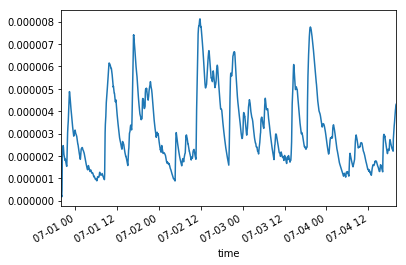

In [504]:
volatility = get_daily_volatility(close)
volatility.plot()
mean_volatility = volatility.mean()

In [818]:
def get_daily_volatility(close,time_period=60):
    return close.ewm(time_period).std()

def compute_cusum_return_events(close, h):
    """
    This CUSUM filter computes potential buy/sell signals if an 
    absolute return h is observed relative to a prior high or low
    """
    time_events, s_pos, s_neg = [], 0, 0
    diff = np.log(close).diff().dropna()
    for i in tqdm(diff.index[1:]):
        pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        s_pos, s_neg = max(0., pos), min(0., neg)
        
        if s_neg<-h:
            s_neg=0
            time_events.append(i)
        elif s_pos>h:
            s_pos=0
            time_events.append(i)
            
    return pd.DatetimeIndex(time_events)

def add_barriers(close,events,side,volatility):
    """
    close: indexed series of close prices
    events: index representing potential entry signals (for example computed by a cusum filter)
    volatility: 30min volatility of the time series
    """
    #1) compute vertical barriers
    vertical_barriers=close.index.searchsorted(events+pd.Timedelta(minutes=30))
    vertical_barriers=vertical_barriers[vertical_barriers<close.shape[0]]
    vertical_barriers=(pd.Series(close.index[vertical_barriers],index=events[:vertical_barriers.shape[0]]))
    
    #2) compute thresholds
    threshold=volatility.loc[events]
#     threshold=threshold[threshold>minimum_return]
    # This probably leaves NAN for rows where the threshold is not exceeeded     
            
    #2) form events object, apply stop loss on the vertical barriers
#     side=pd.Series(1.,index=threshold.index)
    events=pd.concat({'vertical_barrier': vertical_barriers, 'threshold': threshold,'side': side }, axis=1).dropna(subset=['threshold'])
    df0 = apply_profit_taking_and_stop_losses(close, events)    
        
    #3) we replace NaT by a very large date in order to compare values
    df0['take_profit'][pd.isnull(df0['take_profit'])] = pd.Timestamp(pd.Timestamp(2100, 1, 1, 1), tz='US/Eastern')
    df0['stop_loss'][pd.isnull(df0['stop_loss'])] = pd.Timestamp(pd.Timestamp(2100, 1, 1, 1), tz='US/Eastern')

    events['entry_signal'] = df0.index
    events['take_profit'] = df0['take_profit']
    events['stop_loss'] = df0['stop_loss']
    events['vertical_barrier'] = df0['vertical_barrier']
    events['exit_signal'] = df0['take_profit']
#     events['exit_signal'] = df0[['take_profit', 'stop_loss', 'vertical_barrier']].dropna(how='all').min(axis=1)
    return events

def apply_profit_taking_and_stop_losses(close,events):
    out = events[['vertical_barrier']].copy(deep=True)
    take_profits=events['threshold']
    stop_losses=-events['threshold']
    
    for start,end in events['vertical_barrier'].fillna(close.index[-1]).iteritems():
        df0=close[start:end] # path prices
        df0=(df0/close[start]-1)*events.at[start,'side'] # path returns
        out.loc[start,'stop_loss']=df0[df0<stop_losses[start]].index.min() # earliest stop loss.
        out.loc[start,'take_profit']=df0[df0>take_profits[start]].index.min() # earliest profit taking.
        
    return out



def compute_labels_from_returns(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's start time
    -events['vertical_barrier'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) compute prices at time of exit with the backfill method
    events = events.copy()
    events = events.dropna(subset=['exit_signal'])
    price_index = events.index.union(events['exit_signal']).drop_duplicates()
    prices = close.reindex(price_index,method='bfill')
    
    #2) create labels object
    labels = pd.DataFrame(index=events.index)
    labels['returns'] = prices.loc[events['exit_signal']].values/prices.loc[events.index]-1
    labels['label'] = np.sign(labels['returns'])
        
    return labels


def compute_labels_from_metalabels(events, close):
    '''
    In this algorithm, the trading side have been chosen so instead of having {1, -1} labels,
    we have labels that are either 0 or 1. A 0 label means we decide not too trade, 
    a 1 label means we decide to trade. 
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's start time
    -events['vertical_barrier'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) compute prices at time of exit with the backfill method
    events = events.copy()
    events = events.dropna(subset=['exit_signal'])
    price_index = events.index.union(events['exit_signal']).drop_duplicates()
    prices = close.reindex(price_index, method='bfill')
    
    #2) create labels object
    labels = pd.DataFrame(index=events.index)
    entry_signals = events.index
    exit_signals = events['exit_signal']
    labels['returns'] = prices.loc[exit_signals].values / prices.loc[entry_signals]-1
    
    #3) meta-labeling
    labels['returns'] *= events['side'] 
    labels['label'] = np.sign(labels['returns'])
    labels.loc[labels['returns'] <= 0,'label'] = 0
        
    return labels


def compute_labels_3(events, close):
    """
    Compute labels with metalabels (e.g. sides determined by a previous algorithm)
    """
    #1) prices aligned with events
    events = events.copy()
    events = events.dropna(subset=['vertical_barriers'])
    prices = events.index.union(events['vertical_barriers']).drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    #2) create return object
    labels = pd.DataFrame(index=events.index)
    entry_signals = events.index
    exit_signals = events['exit_signal']
    
    labels['returns'] = prices.loc[exit_signals].values / prices.loc[entry_signals] - 1
    labels.loc[labels['returns']<=0,'label'] = 0

    return labels


def compute_labels_4(events, close):
    """
    Compute labels without metalabels (e.g. sides determined by a previous algorithm)
    """
    #1) prices aligned with events
    events = events.copy()
    events = events.dropna(subset=['vertical_barriers'])
    price_index = events.index.union(events['vertical_barriers']).drop_duplicates()
    prices = close.reindex(price_index, method='bfill')
    
    #2) create return object
    labels = pd.DataFrame(index=events.index)
    entry_signals = events.index
    exit_signals = events['exit_signal']
    labels['returns'] = prices.loc[exit_signals].values / prices.loc[entry_signals] - 1
    
    vtouch_first_idx = events[events['exit_signal'].isin(events['vertical_barrier'])].index
    labels.loc[vtouch_first_idx, 'label'] = 0.
    
    return labels


def add_labels_from_returns(events, close):
    events = events.copy()
    labels = compute_labels_from_returns(events, close)
    events = pd.concat([events, labels], axis=1)
    
    return events
    

def add_labels_from_metalabels(events, close):
    events = events.copy()
    labels = compute_labels_from_metalabels(events, close)
    events = pd.concat([events, labels], axis=1)
    
    return events

In [819]:
horizontal_barrier_threshold = 2000 * mean_volatility
minimum_return = 1.5 * mean_volatility
events = compute_cusum_return_events(close, h=horizontal_barrier_threshold)
signals = pd.Series(1., index=events)


events = close.index
signals = pd.Series(1., index=events)
events = add_barriers(close, events, signals, volatility)

100%|██████████| 5755/5755 [00:00<00:00, 6696.47it/s]
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [839]:
# events1 = events.copy()
# events1['take_profit'].dtype
# events1['exit_signal'] = events[['take_profit', 'stop_loss', 'vertical_barrier']].dropna(how='all').min(axis=1)
# events1.head()

vertical_barriers=close.index.searchsorted(close.index+pd.Timedelta(minutes=30))
vertical_barriers=vertical_barriers[vertical_barriers<close.shape[0]]
vertical_barriers=(pd.Series(close.index[vertical_barriers],index=events[:vertical_barriers.shape[0]]))
vertical_barriers.head()

#2) compute thresholds
threshold=volatility.loc[close.index]
#     threshold=threshold[threshold>minimum_return]
# This probably leaves NAN for rows where the threshold is not exceeeded     

#2) form events object, apply stop loss on the vertical barriers
#     side=pd.Series(1.,index=threshold.index)
events=pd.concat({'vertical_barrier': vertical_barriers, 'threshold': threshold,'side': side }, axis=1).dropna(subset=['threshold'])
df0 = apply_profit_taking_and_stop_losses(close, events)    

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py:526: RuntimeWarning: Cannot compare type 'Timestamp' with type 'tuple', sort order is undefined for incomparable objects
  this = Index.union(this, other)


In [832]:
events1 = add_labels_from_returns(events, close)
events1.label.value_counts()

1.0    4575
Name: label, dtype: int64

In [737]:
events = add_labels_from_metalabels(events, close)
events.label.value_counts()

0.0    27
1.0    15
Name: label, dtype: int64

In [662]:
fast_window = 3
slow_window = 6

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))

,price,fast,slow
time,,,
2019-06-30 20:02:00-04:00,0.000542,0.000542,0.000542
2019-06-30 20:03:00-04:00,0.000542,0.000542,0.000542
2019-06-30 20:04:00-04:00,0.000542,0.000542,0.000542
2019-06-30 20:05:00-04:00,0.000542,0.000542,0.000542
2019-06-30 20:06:00-04:00,0.000542,0.000542,0.000542


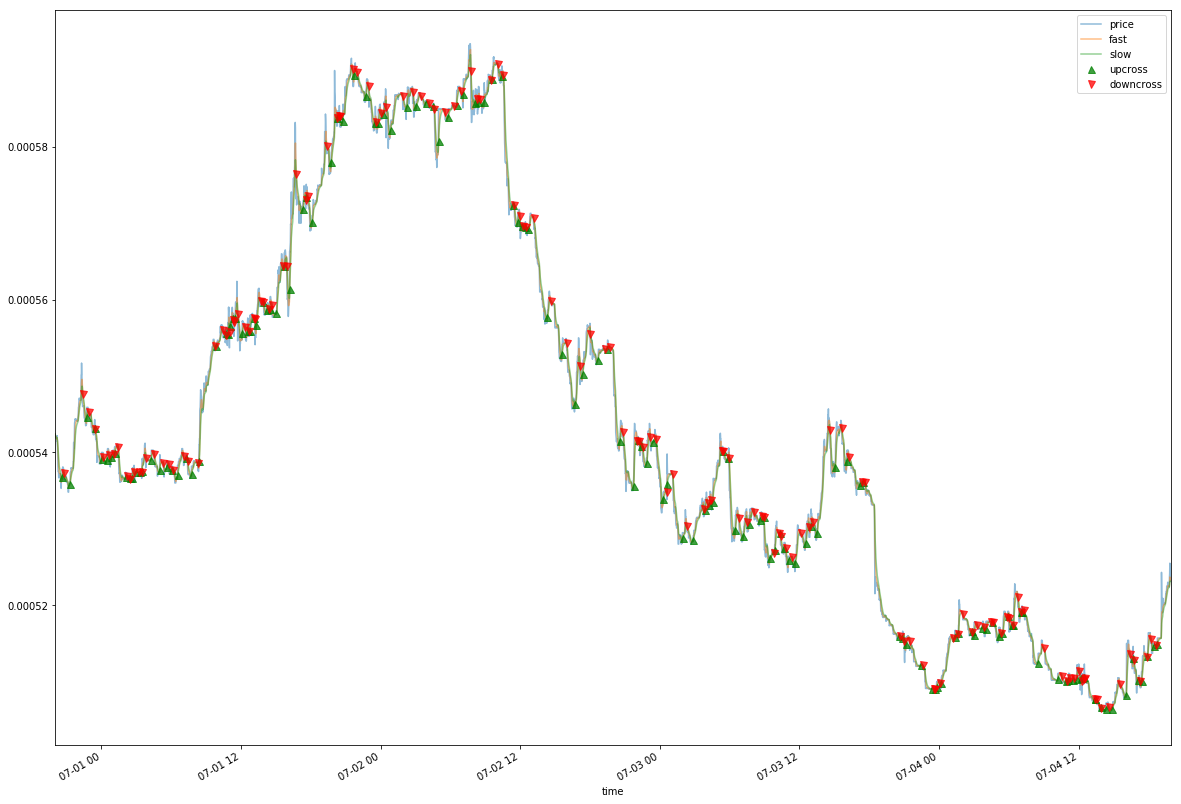

In [743]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[crit1 & crit2]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[crit1 & crit2]

def compute_signals(close_df):
    up = get_up_cross(close_df)
    down = get_down_cross(close_df)
    signals_up = pd.Series(1, index=up.index)
    signals_down = pd.Series(-1, index=down.index)
    signals = pd.concat([signals_up, signals_down]).sort_index()
    return up, down, signals

def plot_signals(close_df):
    up, down, _ = compute_signals(close_df)
    f, ax = plt.subplots(figsize=(20,15))
    close_df.plot(ax=ax, alpha=0.5)
    up.plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='upcross', color='g')
    down.plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='downcross', color='r')
    ax.legend()


up, down, signals = compute_signals(close_df)
plot_signals(close_df)

In [746]:
minimum_return = 0.01
classification_type = [1,1]
volatility = get_daily_volatility(close)
mean_volatility = volatility.mean()
horizontal_barrier_threshold = 2000 * mean_volatility
minimum_return = 1.5 * mean_volatility

# Apply a CUSUM filter if needed.
# events = compute_cusum_return_events(close, h=horizontal_barrier_threshold)
events = add_barriers(close, close.index, signals, volatility, minimum_return)
ma_strategy_events = add_labels_from_metalabels(events, close)

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/pandas/core/common.py:232: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old beha

In [749]:
print('Sides')
print(ma_strategy_events.side.value_counts())
print('\nEvents dataframe')
ma_strategy_events.head()
ma_strategy_trading_events = ma_strategy_events.dropna(subset=['label'])

Sides
-1.0    28
 1.0    25
Name: side, dtype: int64

Events dataframe


In [759]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

df = ma_strategy_events.dropna(subset=['label'])
X = df.side.values.reshape(-1,1)
y = df.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
n_estimator = 10000

model = RandomForestClassifier(max_depth=2, n_estimators=n_estimator, criterion='entropy')
model.fit(X_train, y_train)

# The random forest model by itself
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.21      0.50      0.30         6
         1.0       0.77      0.48      0.59        21

   micro avg       0.48      0.48      0.48        27
   macro avg       0.49      0.49      0.44        27
weighted avg       0.65      0.48      0.52        27



## Bollinger Bands Strategy

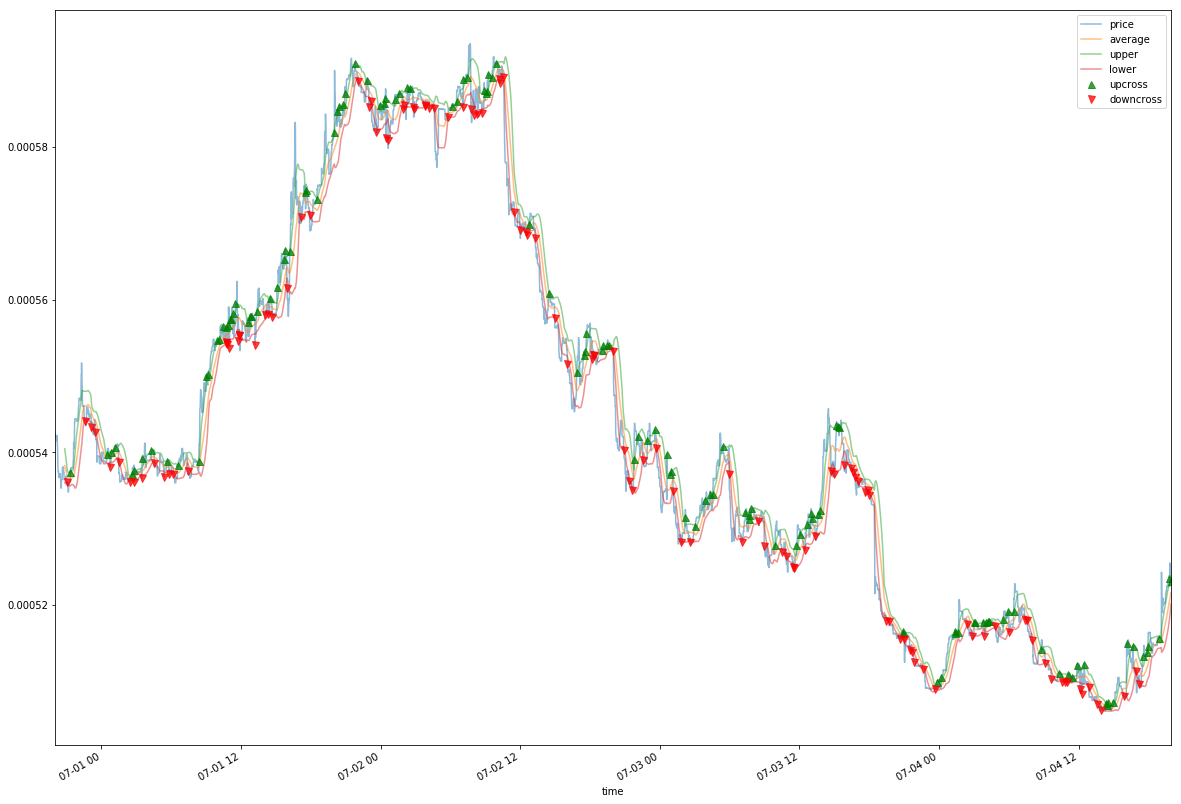

In [769]:
def bollinger_bands(price, window=None, width=None, num_sd=None):
    """
    Returns average, upper band, and lower band
    """
    av = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upper_band = av * (1 + width)
        lower_band = av * (1 - width)
        
    if num_sd:
        upper_band = av + (sd * num_sd)
        lower_band = av - (sd * num_sd)
        
    return pd.DataFrame({
        'price': price,
        'average': av,
        'upper': upper_band,
        'lower': lower_band
    })

def compute_bollinger_bands_signals(df):
    def get_up_cross(df, col):
        # col is price column
        crit1 = df[col].shift(1) < df.upper.shift(1)  
        crit2 = df[col] > df.upper
        return df[col][(crit1) & (crit2)]

    def get_down_cross(df, col):
        # col is price column    
        crit1 = df[col].shift(1) > df.lower.shift(1) 
        crit2 = df[col] < df.lower
        return df[col][(crit1) & (crit2)]
    
    up = get_up_cross(df, 'price')
    down = get_down_cross(df, 'price')
    signals_up = pd.Series(1, index=up.index)
    signals_down = pd.Series(-1, index=down.index)
    signals = pd.concat([signals_up, signals_down]).sort_index()
    return up, down, signals


def plot_bollinger_bands(df):
    """
    """
    up, down, _ = compute_bollinger_bands_signals(df)
    
    f, ax = plt.subplots(figsize=(20,15))
    df.plot(ax=ax, alpha=0.5)
    up.plot(ax=ax, ls='', marker='^', markersize=7, alpha=0.75, label='upcross', color='g')
    down.plot(ax=ax, ls='', marker='v', markersize=7, alpha=0.75, label='downcross', color='r')
    ax.legend()
    


bollinger_bands_df = bollinger_bands(close, window=50, num_sd=1)
plot_bollinger_bands(bollinger_bands_df)
_, _, signals = compute_bollinger_bands_signals(bollinger_bands_df)

In [771]:
minimum_return = 0.01
classification_type = [1,1]
volatility = get_daily_volatility(close)
mean_volatility = volatility.mean()
horizontal_barrier_threshold = 2000 * mean_volatility
minimum_return = 1.5 * mean_volatility

# Apply a CUSUM filter if needed.
# events = compute_cusum_return_events(close, h=horizontal_barrier_threshold)
events = add_barriers(close, close.index, signals, volatility, minimum_return)
bollinger_bands_strategy_events = add_labels_from_metalabels(events, close)
bollinger_bands_strategy_events.head()
trading_events = bollinger_bands_strategy_events.dropna(subset=['label'])

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [773]:
trading_events.head()

,side,threshold,vertical_barrier,entry_signal,take_profit,stop_loss,exit_signal,returns,label
time,,,,,,,,,
2019-07-01 09:11:00-04:00,1.0,0.000005,2019-07-01 09:41:00-04:00,2019-07-01 09:11:00-04:00,2019-07-01 09:12:00-04:00,2100-01-01 01:00:00-05:00,2019-07-01 09:12:00-04:00,0.000727,1.0
2019-07-01 09:59:00-04:00,1.0,0.000006,2019-07-01 10:29:00-04:00,2019-07-01 09:59:00-04:00,2019-07-01 10:09:00-04:00,2019-07-01 10:01:00-04:00,2019-07-01 10:01:00-04:00,-0.000180,0.0
2019-07-01 10:09:00-04:00,1.0,0.000006,2019-07-01 10:39:00-04:00,2019-07-01 10:09:00-04:00,2019-07-01 10:10:00-04:00,2019-07-01 10:39:00-04:00,2019-07-01 10:10:00-04:00,0.000180,1.0
2019-07-01 10:25:00-04:00,1.0,0.000006,2019-07-01 10:55:00-04:00,2019-07-01 10:25:00-04:00,2019-07-01 10:53:00-04:00,2019-07-01 10:28:00-04:00,2019-07-01 10:28:00-04:00,-0.000898,0.0
2019-07-01 10:41:00-04:00,-1.0,0.000005,2019-07-01 11:11:00-04:00,2019-07-01 10:41:00-04:00,2019-07-01 10:45:00-04:00,2019-07-01 10:42:00-04:00,2019-07-01 10:42:00-04:00,-0.002345,0.0


In [777]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""
    return df.rolling(window=window).corr(df.shift(lag))

features = (pd.DataFrame()
           .assign(volatility=trading_events.threshold)
           .assign(serial_correlation=df_rolling_autocorr(returns(close), window=50))
           .drop_duplicates()
           .dropna())
            
        

In [778]:
features.head()

,volatility,serial_correlation
time,,
2019-07-01 09:11:00-04:00,0.000005,0.166473
2019-07-01 09:59:00-04:00,0.000006,0.336068
2019-07-01 10:09:00-04:00,0.000006,0.316574
2019-07-01 10:25:00-04:00,0.000006,-0.238171
2019-07-01 10:41:00-04:00,0.000005,-0.229945


In [783]:
Xy = pd.concat([features, trading_events[['label']]], axis=1).dropna()

              precision    recall  f1-score   support

    no_trade       0.33      0.12      0.18         8
       trade       0.65      0.87      0.74        15

   micro avg       0.61      0.61      0.61        23
   macro avg       0.49      0.50      0.46        23
weighted avg       0.54      0.61      0.55        23



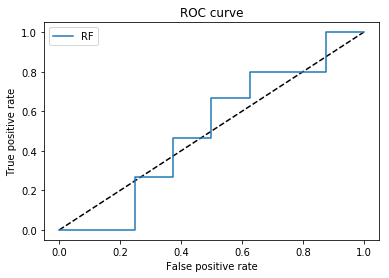

In [791]:
X = Xy.drop('label', axis=1).values
y = Xy['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
n_estimators = 10000
model = RandomForestClassifier(max_depth=2, n_estimators=n_estimators, criterion='entropy')
model.fit(X_train, y_train)


y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [795]:
pd.crosstab(y_test, y_pred, rownames=['Actual labels'], colnames=['Predicted labels'])

Predicted labels,0.0,1.0
Actual labels,,
0.0,1,7
1.0,2,13


In [798]:
list(zip(features.columns, model.feature_importances_))

[('volatility', 0.480196423364229), ('serial_correlation', 0.5198035766357715)]

In [800]:
Xy

,volatility,serial_correlation,label
time,,,
2019-07-01 09:11:00-04:00,0.000005,0.166473,1.0
2019-07-01 09:59:00-04:00,0.000006,0.336068,0.0
2019-07-01 10:09:00-04:00,0.000006,0.316574,1.0
2019-07-01 10:25:00-04:00,0.000006,-0.238171,0.0
2019-07-01 10:41:00-04:00,0.000005,-0.229945,0.0
2019-07-01 10:43:00-04:00,0.000005,-0.115077,0.0
2019-07-01 10:45:00-04:00,0.000005,-0.073296,0.0
2019-07-01 10:49:00-04:00,0.000005,-0.204715,1.0
2019-07-01 10:53:00-04:00,0.000005,-0.130804,1.0


In [840]:
close.index

DatetimeIndex(['2019-06-30 20:02:00-04:00', '2019-06-30 20:03:00-04:00',
               '2019-06-30 20:04:00-04:00', '2019-06-30 20:05:00-04:00',
               '2019-06-30 20:06:00-04:00', '2019-06-30 20:07:00-04:00',
               '2019-06-30 20:08:00-04:00', '2019-06-30 20:09:00-04:00',
               '2019-06-30 20:10:00-04:00', '2019-06-30 20:11:00-04:00',
               ...
               '2019-07-04 19:49:00-04:00', '2019-07-04 19:50:00-04:00',
               '2019-07-04 19:51:00-04:00', '2019-07-04 19:52:00-04:00',
               '2019-07-04 19:53:00-04:00', '2019-07-04 19:54:00-04:00',
               '2019-07-04 19:55:00-04:00', '2019-07-04 19:56:00-04:00',
               '2019-07-04 19:57:00-04:00', '2019-07-04 19:58:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='time', length=5757, freq='T')

In [846]:
trading_events['vertical_barrier']

time
2019-07-01 09:11:00-04:00   2019-07-01 09:41:00-04:00
2019-07-01 09:59:00-04:00   2019-07-01 10:29:00-04:00
2019-07-01 10:09:00-04:00   2019-07-01 10:39:00-04:00
2019-07-01 10:25:00-04:00   2019-07-01 10:55:00-04:00
2019-07-01 10:41:00-04:00   2019-07-01 11:11:00-04:00
2019-07-01 10:43:00-04:00   2019-07-01 11:13:00-04:00
2019-07-01 10:45:00-04:00   2019-07-01 11:15:00-04:00
2019-07-01 10:49:00-04:00   2019-07-01 11:19:00-04:00
2019-07-01 10:53:00-04:00   2019-07-01 11:23:00-04:00
2019-07-01 11:00:00-04:00   2019-07-01 11:30:00-04:00
2019-07-01 11:02:00-04:00   2019-07-01 11:32:00-04:00
2019-07-01 11:09:00-04:00   2019-07-01 11:39:00-04:00
2019-07-01 17:08:00-04:00   2019-07-01 17:38:00-04:00
2019-07-01 17:32:00-04:00   2019-07-01 18:02:00-04:00
2019-07-01 17:36:00-04:00   2019-07-01 18:06:00-04:00
2019-07-01 17:54:00-04:00   2019-07-01 18:24:00-04:00
2019-07-01 20:18:00-04:00   2019-07-01 20:48:00-04:00
2019-07-01 20:27:00-04:00   2019-07-01 20:57:00-04:00
2019-07-01 21:49:00-04: